# Group Members:
A91050002: Jingxiao Zhang

A92094901: Tianyu Ma

A12238337: Arvin Dagoc

A12008027: Sahil Bansal

A99112867: Momin Khan

# Introduction and Background

Travel by plane is commonplace domestically. Whether it be for vacation, family visits, or school, many Americans fly to other parts of the country. Naturally, flights time often get delayed, especially if it’s at a metropolitan hub.

As college students, many of us have experienced flight delays, so it is an interesting topic to explore. Delay has been analyzed based on destination, time of day, week, or month, and even based on flight duration. However, we are interested in analyzing the reason of delay. Maybe looking into reason of delay and how it relates to other factors can give us insights about how to travel smarter.


### Research Question

We want to figure out what the major reason for flight delays is. Is there some relationship between the popularity of a destination and the reason of delay? How are popularity of destination, time of year, and reason for delay related to each other?

### Hypothesis

We think that Late aircraft delay is the major reason for flight delays. Late aircraft delay is when a flight is late because another flight with the same aircraft arrives late. We also think there is a relationship between destination and delay reason. More specifically that Late aircraft delay is not a problem with unpopular destinations.  We think that time of year affects popularity of destination but not reason of delay. 


### Imports


In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

#countFrequencyofDelay 
#findMostPopularDestinationOfMonth 
#plotReasonofDelaywithDestination

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Data Description

We are using domestic flight data from the Bureau of Transportation Statistics. The datasets are from years 2005, 2006, 2007, and 2008. Datasets include features we are interested in like the minutes of delay, destinatinon, and the reasons for delay. There are also extraneous features we are going to ignore. 

In [2]:
df_2005 = pd.read_csv('2005.csv')
df_2006 = pd.read_csv('2006.csv')
df_2007 = pd.read_csv('2007.csv')
df_2008 = pd.read_csv('2008.csv')

In [3]:
frames = [df_2005,df_2006,df_2007,df_2008]
df = pd.concat(frames)
df.head(10)

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2005,1,28,5,1603.0,1605,1741.0,1759,UA,541,...,4.0,23.0,0,NaN,0,0.0,0.0,0.0,0.0,0.0
1,2005,1,29,6,1559.0,1605,1736.0,1759,UA,541,...,6.0,15.0,0,NaN,0,0.0,0.0,0.0,0.0,0.0
2,2005,1,30,7,1603.0,1610,1741.0,1805,UA,541,...,9.0,18.0,0,NaN,0,0.0,0.0,0.0,0.0,0.0
3,2005,1,31,1,1556.0,1605,1726.0,1759,UA,541,...,11.0,10.0,0,NaN,0,0.0,0.0,0.0,0.0,0.0
4,2005,1,2,7,1934.0,1900,2235.0,2232,UA,542,...,5.0,10.0,0,NaN,0,0.0,0.0,0.0,0.0,0.0
5,2005,1,3,1,2042.0,1900,9.0,2232,UA,542,...,3.0,47.0,0,NaN,0,23.0,0.0,0.0,0.0,74.0
6,2005,1,4,2,2046.0,1900,2357.0,2232,UA,542,...,5.0,26.0,0,NaN,0,46.0,0.0,0.0,0.0,39.0
7,2005,1,5,3,NaN,1900,NaN,2232,UA,542,...,0.0,0.0,1,B,0,0.0,0.0,0.0,0.0,0.0
8,2005,1,6,4,2110.0,1900,8.0,2223,UA,542,...,2.0,15.0,0,NaN,0,16.0,0.0,0.0,0.0,89.0
9,2005,1,7,5,1859.0,1900,2235.0,2223,UA,542,...,4.0,56.0,0,NaN,0,0.0,0.0,0.0,0.0,0.0


# Data Cleaning/Pre processing 

In [4]:
df_final = df.copy()

We remove extraneous columns of data

In [5]:
df_final = df_final[['Year', 'Month', 'UniqueCarrier', 'ArrDelay', 'DepDelay', 'Dest','Cancelled', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']]

In [6]:
df_final = df_final[df_final['Cancelled'] == 0]

In [7]:
df_final['Season'] = df_final['Month']
#df_final["Dest"].value_counts()

In [8]:
def standardize_season(month):
    if month in [12, 1, 2]:
        output = "winter"
    elif month in [3, 4, 5]:
        output = "spring"
    elif month in [6, 7, 8]:
        output = "summer"
    elif month in [9, 10, 11]:
        output = "fall"
    return output

In [9]:
df_final['Season'] = df_final['Season'].apply(standardize_season)

In [10]:
df_final.head(100)

,Year,Month,UniqueCarrier,ArrDelay,DepDelay,Dest,Cancelled,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Season
0,2005,1,UA,-18.0,-2.0,ORD,0,0.0,0.0,0.0,0.0,0.0,winter
1,2005,1,UA,-23.0,-6.0,ORD,0,0.0,0.0,0.0,0.0,0.0,winter
2,2005,1,UA,-24.0,-7.0,ORD,0,0.0,0.0,0.0,0.0,0.0,winter
3,2005,1,UA,-33.0,-9.0,ORD,0,0.0,0.0,0.0,0.0,0.0,winter
4,2005,1,UA,3.0,34.0,BOS,0,0.0,0.0,0.0,0.0,0.0,winter
5,2005,1,UA,97.0,102.0,BOS,0,23.0,0.0,0.0,0.0,74.0,winter
6,2005,1,UA,85.0,106.0,BOS,0,46.0,0.0,0.0,0.0,39.0,winter
8,2005,1,UA,105.0,130.0,BOS,0,16.0,0.0,0.0,0.0,89.0,winter
9,2005,1,UA,12.0,-1.0,BOS,0,0.0,0.0,0.0,0.0,0.0,winter
10,2005,1,UA,-18.0,-1.0,BOS,0,0.0,0.0,0.0,0.0,0.0,winter


In [11]:
df_final[df_final['Season'] == 'fall']['Dest'].value_counts()

ATL    404256
ORD    345478
DFW    286828
LAX    220929
DEN    220042
PHX    192160
IAH    190718
LAS    174083
DTW    143222
EWR    142862
SLC    141996
SFO    132110
MSP    128340
CVG    125594
BOS    119154
CLT    118562
LGA    117587
MCO    116319
JFK    111950
SEA    105323
BWI    105056
PHL    103861
MDW     92844
SAN     91072
DCA     89511
IAD     87449
CLE     74138
TPA     72891
OAK     68657
MEM     62895
        ...  
BLI       262
HKY       260
HVN       259
LWB       247
BPT       228
SLE       224
YKM       178
ILG       168
AKN       166
CMX       164
ALO       148
RHI       141
SUX       135
PLN       115
DLG       114
SOP       112
ADK        95
ITH        90
ACK        65
INL        55
BJI        38
TTN        30
MKG        18
PVU         4
PIR         4
OGD         4
PUB         2
RCA         1
CYS         1
EAU         1
Name: Dest, Length: 313, dtype: int64

In [12]:
df_final['Dest'].value_counts()

ATL    1626680
ORD    1381040
DFW    1160142
LAX     905907
DEN     883619
IAH     810097
PHX     790141
LAS     702622
DTW     591918
EWR     586503
SLC     583586
MSP     540985
SFO     529662
CVG     523859
MCO     494675
BOS     489943
CLT     476917
LGA     475414
JFK     446749
PHL     429938
SEA     427706
BWI     422842
IAD     375085
MDW     373152
SAN     369108
DCA     364916
CLE     314606
TPA     311025
OAK     279136
FLL     271605
        ...   
SUX        594
CMX        575
ALO        546
OTH        504
VCT        501
LMT        499
PIE        463
VIS        417
RHI        412
MKG        391
ADK        378
GST        338
SOP        311
INL        269
BJI        189
MTH        126
ITH        125
EAU         66
OGD         16
CYS         11
PVU          9
PIR          9
PUB          9
GLH          2
FMN          2
LAR          2
LBF          1
MKC          1
RCA          1
BFF          1
Name: Dest, Length: 325, dtype: int64

# Data Visualization

In [13]:
dfgb1 = df_final.groupby(['Dest', 'Month'])
df_mean_by_apdest = dfgb1.agg(['mean'])
df_mean_by_apdest

Year   ArrDelay   DepDelay Cancelled CarrierDelay  \
                   mean       mean       mean      mean         mean   
Dest Month                                                             
ABE  1      2006.504147  12.738295  14.816943         0     7.361777   
     2      2006.431669  11.159868  13.394875         0     7.067181   
     3      2006.505803   9.377370  12.581552         0     6.498523   
     4      2006.535693   5.856383   8.689086         0     4.630227   
     5      2006.467137   3.374796   6.782727         0     4.203504   
     6      2006.524331  15.784278  16.674574         0     7.414141   
     7      2006.537332  15.083436  17.042228         0     8.433770   
     8      2006.515062   9.984643  12.450679         0     6.100579   
     9      2006.506761   5.889032   8.502254         0     6.332543   
     10     2006.626604   5.444769   8.063011         0     6.217860   
     11     2006.604771   4.542931   7.000000         0     4.259984   
     12     2006.548177  14.477154  17.385417         0     8.578989   
ABI  1      2006.465462   7.132337   9.226355         0     5.457516   
     2      2006.478652   8.487064   9.539326         0     4.375698   
     3      2006.411576  10.883047  12.762058         0     6.006274   
     4      2006.405022  10.156114  10.671397         0     5.325459   
     5      2006.406744  11.803590  13.500527         0     5.107323   
     6      2006.533409  18.040770  20.138165         0     6.467225   
     7      2006.539804  18.213740  19.611778         0     8.769863   
     8      2006.539130  17.136017  17.680435         0     7.018617   
     9      2006.546893   6.823729   9.263277         0     5.350365   
     10     2006.501661   4.447398   7.331118         0     4.305750   
     11     2006.501746   4.327506   7.352736         0     4.248902   
     12     2006.496018  17.175199  18.734926         0     8.505510   
ABQ  1      2006.557052   6.273550   9.244254         0     3.664531   
     2      2006.567108   7.635778  10.628042         0     3.778840   
     3      2006.549396   6.980771  10.614239         0     4.061699   
     4      2006.567833   4.300496   7.228188         0     2.830865   
     5      2006.578051   5.152407   8.386975         0     3.318715   
     6      2006.578600   9.437100  12.398943         0     4.417165   
...                 ...        ...        ...       ...          ...   
YAK  7      2006.502058  12.128099  11.090535         0     4.644670   
     8      2006.500000  26.235537  25.008197         0     4.892683   
     9      2006.489362  12.591489  11.714894         0     1.869110   
     10     2006.479339   5.933610   5.628099         0     5.529126   
     11     2006.500000  -3.195455   0.084821         0     3.632184   
     12     2006.462222  10.470320  15.346667         0     1.326531   
YKM  1      2008.000000  18.387097   7.032258         0    26.166667   
     2      2008.000000  11.750000   2.275000         0    16.384615   
     3      2008.000000  12.132075  -1.075472         0    10.533333   
     4      2008.000000   7.690909  -2.109091         0     3.750000   
     5      2008.000000  -1.520000  -0.520000         0    16.000000   
     6      2007.384615   4.743590   2.730769         0     6.020000   
     7      2007.473684   4.236842   0.824561         0     5.171875   
     8      2007.436364   5.918182   2.572727         0     6.169231   
     9      2007.000000   5.135593  -2.508475         0     3.661017   
     10     2007.000000   5.048387  -1.209677         0     5.564516   
     11     2007.000000   8.719298  -1.228070         0     2.701754   
     12     2007.000000  26.683333   9.066667         0    17.633333   
YUM  1      2006.896818   9.191120   8.662488         0    10.369771   
     2      2006.900318   7.090138   7.296925         0     9.957576   
     3      2006.880976   5.870841   7.827317         0    10.350778   
     4      2006.856600   2.878443   4.205128         0    

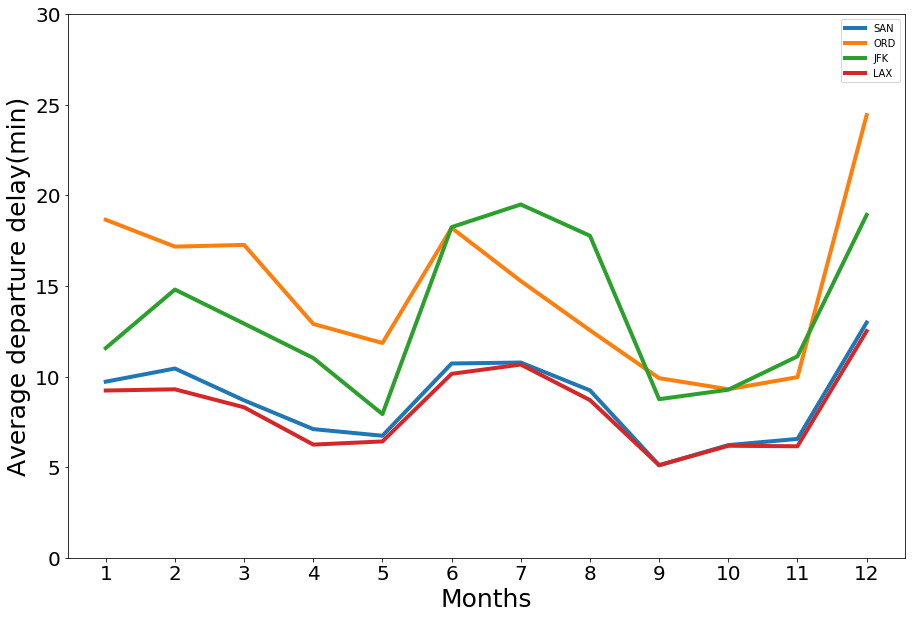

In [14]:
#DepDelays

dests = ['SAN', 'ORD', 'JFK', 'LAX']
plt.figure(figsize = (15,10))
for dest in dests:
    means = df_mean_by_apdest.loc[dest]['DepDelay']['mean'].values
    plt.errorbar(np.arange(1, 13), means, label = dest, linewidth = 4)
plt.ylabel('Average departure delay(min)', size = 25)
plt.xlabel('Months', size = 25)
plt.yticks(np.arange(0, 35, 5), size = 20)
plt.xticks(np.arange(1,13),['1','2','3','4','5','6','7','8','9','10','11','12'], size = 20)
plt.legend()

Low min of departure in months 5 and 9

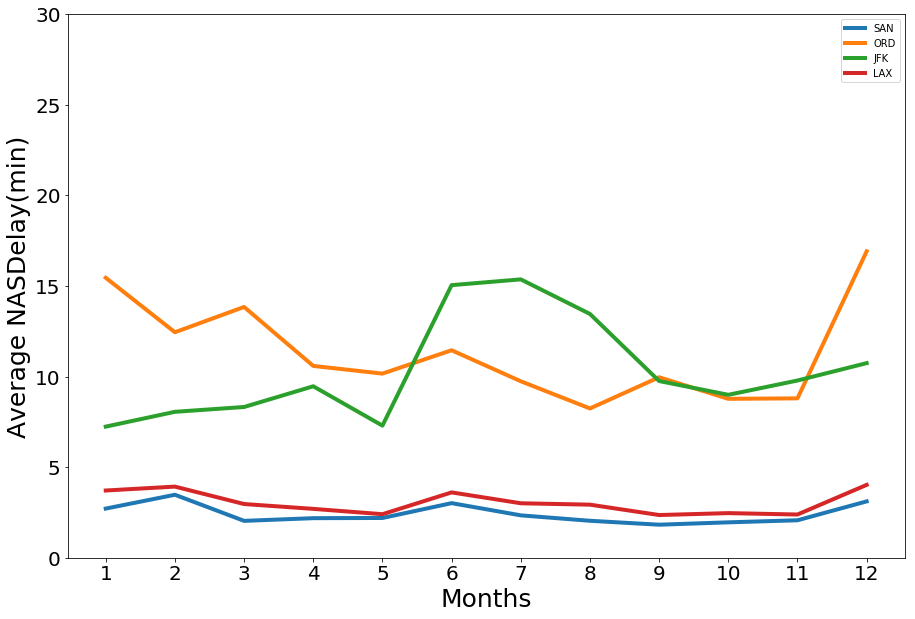

In [15]:
#NASDelay


plt.figure(figsize = (15,10))
for dest in dests:
    means = df_mean_by_apdest.loc[dest]['NASDelay']['mean'].values
    plt.errorbar(np.arange(1, 13), means, label = dest, linewidth = 4)
plt.ylabel('Average NASDelay(min)', size = 25)
plt.xlabel('Months', size = 25)
plt.yticks(np.arange(0, 35, 5), size = 20)
plt.xticks(np.arange(1,13),['1','2','3','4','5','6','7','8','9','10','11','12'], size = 20)
plt.legend()

This reason of delay does not match the overall delay very much 

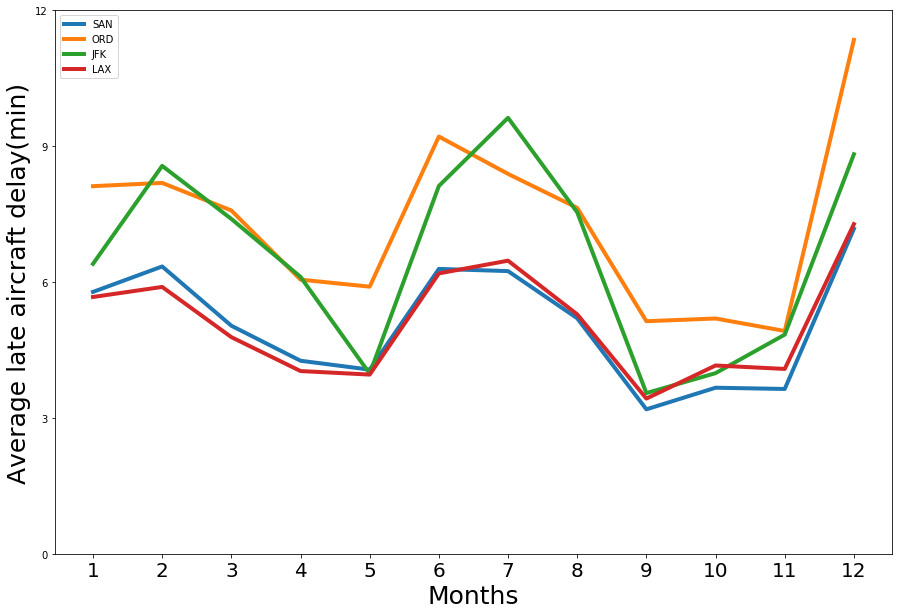

In [16]:
#LateAircraftDelays

plt.figure(figsize = (15,10))
for dest in dests:
    means = df_mean_by_apdest.loc[dest]['LateAircraftDelay']['mean'].values
    plt.errorbar(np.arange(1, 13), means, label = dest, linewidth = 4)
plt.ylabel('Average late aircraft delay(min)', size = 25)
plt.xlabel('Months', size = 25)
plt.yticks(np.arange(0, 15, 3), size = 10)
plt.xticks(np.arange(1,13),['1','2','3','4','5','6','7','8','9','10','11','12'], size = 20)
plt.legend()

This looks similar to the overall delay graph, with low delay in mins in months 5 and 9

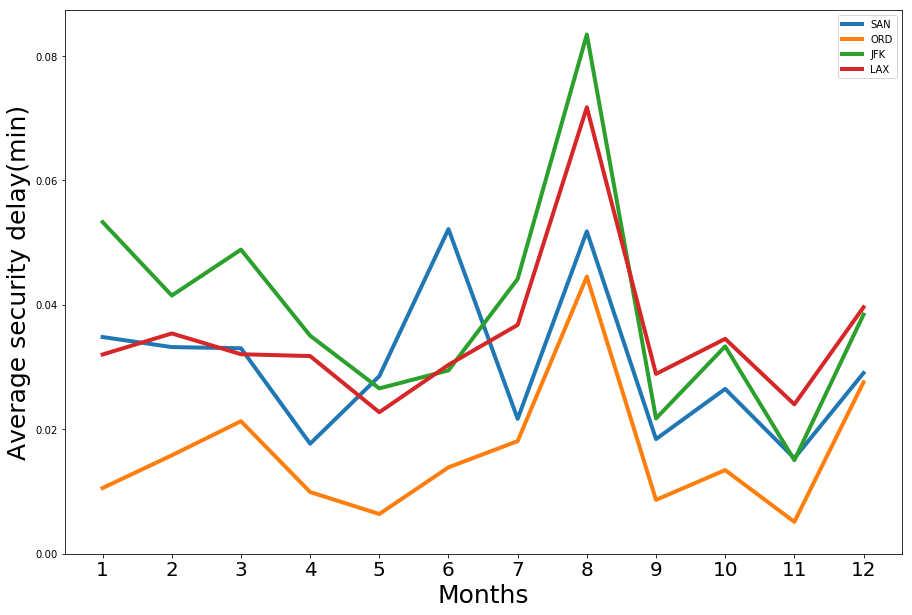

In [17]:
#SecurityDelays

plt.figure(figsize = (15,10))
for dest in dests:
    means = df_mean_by_apdest.loc[dest]['SecurityDelay']['mean'].values
    plt.errorbar(np.arange(1, 13), means, label = dest, linewidth = 4)
plt.ylabel('Average security delay(min)', size = 25)
plt.xlabel('Months', size = 25)
plt.yticks(np.arange(0, 0.1, 0.02), size = 10)
plt.xticks(np.arange(1,13),['1','2','3','4','5','6','7','8','9','10','11','12'], size = 20)
plt.legend()

This graph does not look like the overall delay in mins graph

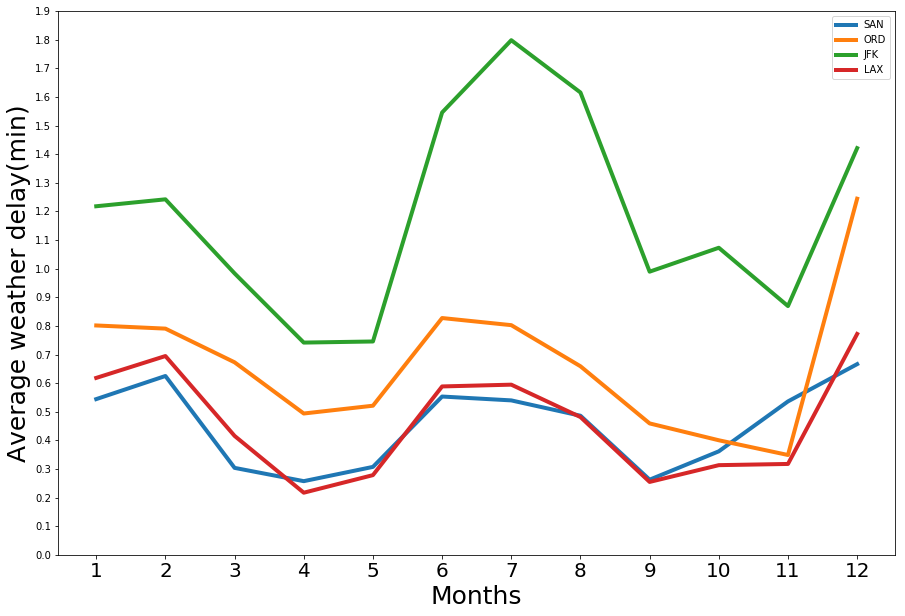

In [18]:
#WeatherDelays

plt.figure(figsize = (15,10))
for dest in dests:
    means = df_mean_by_apdest.loc[dest]['WeatherDelay']['mean'].values
    plt.errorbar(np.arange(1, 13), means, label = dest, linewidth = 4)
plt.ylabel('Average weather delay(min)', size = 25)
plt.xlabel('Months', size = 25)
plt.yticks(np.arange(0, 2, 0.1), size = 10)
plt.xticks(np.arange(1,13),['1','2','3','4','5','6','7','8','9','10','11','12'], size = 20)
plt.legend()

Looks similar to overall delay in minutes, low points at months 5 and 9

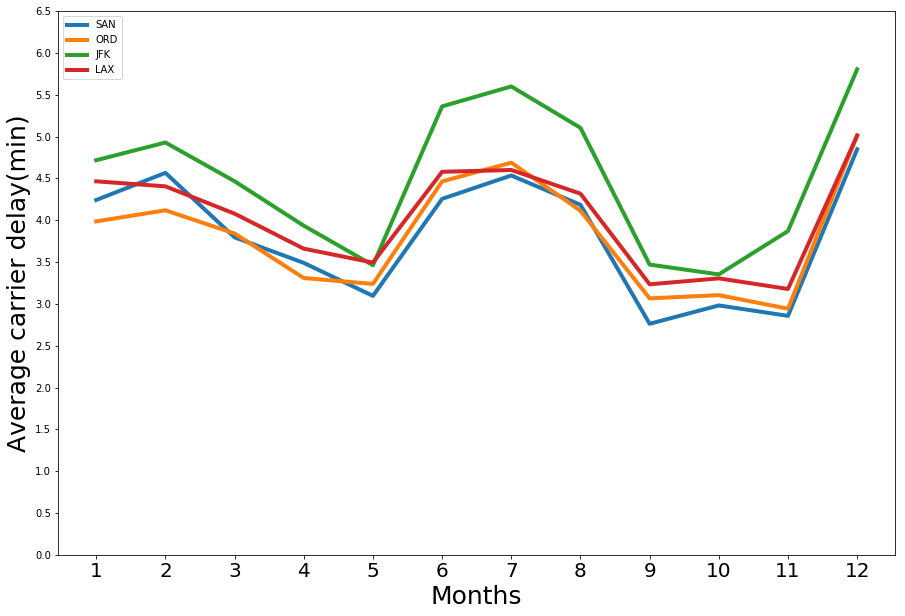

In [19]:
#CarrierDelays

plt.figure(figsize = (15,10))
for dest in dests:
    means = df_mean_by_apdest.loc[dest]['CarrierDelay']['mean'].values
    plt.errorbar(np.arange(1, 13), means, label = dest, linewidth = 4)
plt.ylabel('Average carrier delay(min)', size = 25)
plt.xlabel('Months', size = 25)
plt.yticks(np.arange(0, 7, 0.5), size = 10)
plt.xticks(np.arange(1,13),['1','2','3','4','5','6','7','8','9','10','11','12'], size = 20)
plt.legend()

Looks similar to overall delay in minutes, with low points at months 5 and 9.

We will now try to see what the major reason of delay is in terms of minutes, all on the same graph.

To do this, first let's look at a popoular destination to look at these delay reasons with.

In [20]:
df_final['Dest'].value_counts()[0:1]

ATL    1626680
Name: Dest, dtype: int64

Now let's look for a less popular destination to compare to.

In [21]:
df_final['Dest'].value_counts()[164:165]

RDM    13935
Name: Dest, dtype: int64

So we will be looking at the mean delays in minutes for each reason, for each month. We will first look at this without a specific destination, then look at it with relation to a popular destination 'ATL' and finaly look at it with a less popular destination 'RDM'.

First let's look at a general case, without a specific location. We group by Month and mean to help get us variables for a graph.

In [22]:
dfgb2 = df_final.groupby(['Month'])
df_mean_by_apdest2 = dfgb2.agg(['mean'])
df_mean_by_apdest2

,Year,ArrDelay,DepDelay,Cancelled,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
,mean,mean,mean,mean,mean,mean,mean,mean,mean
Month,,,,,,,,,
1,2006.519296,8.770281,10.183391,0,4.398922,0.995643,4.660540,0.024391,5.584086
2,2006.513668,10.079116,11.179303,0,4.661406,1.050314,4.829308,0.031466,6.153434
3,2006.500476,9.210201,10.813852,0,4.444433,0.801404,4.580312,0.035115,5.890282
4,2006.505769,6.101138,7.848737,0,3.716128,0.583057,3.811203,0.028427,4.615676
5,2006.500478,5.736599,7.446081,0,3.464082,0.616716,3.782311,0.017605,4.444662
6,2006.503999,12.846501,13.412990,0,5.106689,1.261961,5.728112,0.027073,7.202234
7,2006.506906,12.325418,13.413387,0,5.271341,1.266751,5.469942,0.030764,7.346202
8,2006.495365,9.335448,10.836677,0,4.708913,0.954174,4.514669,0.055044,5.978859


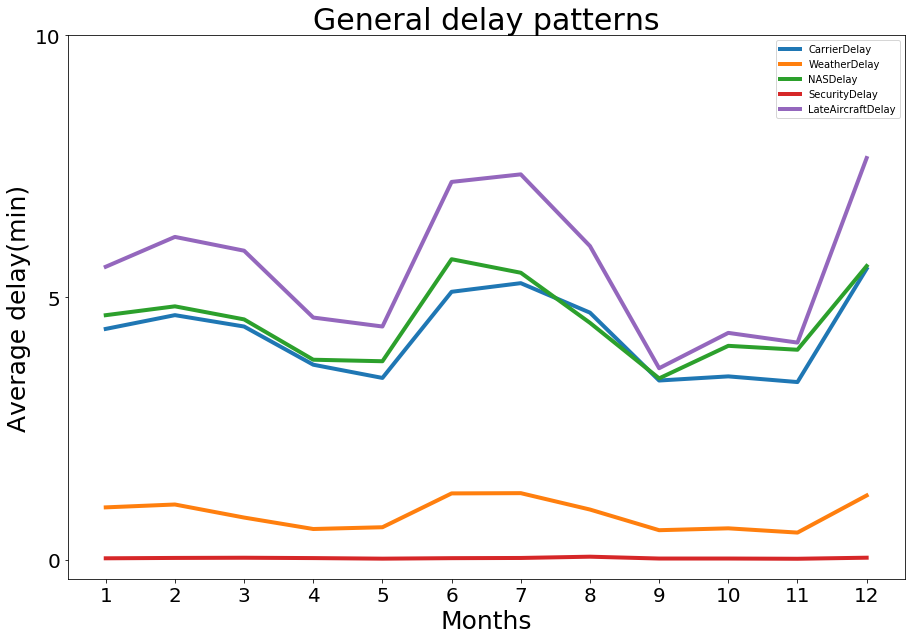

In [23]:
DelayReason = [ 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
plt.figure(figsize = (15,10))
for reason in DelayReason:
    means = df_mean_by_apdest2[reason]['mean'].values
    plt.errorbar(np.arange(1, 13), means, label = reason, linewidth = 4)
plt.ylabel('Average delay(min)', size = 25)
plt.xlabel('Months', size = 25)
plt.yticks(np.arange(0, 15, 5), size = 20)
plt.xticks(np.arange(1,13),['1','2','3','4','5','6','7','8','9','10','11','12'], size = 20)
plt.title('General delay patterns', size=30)
plt.legend()

Now let's look at the same type of graph, but with respect to the popular destination 'ATL'

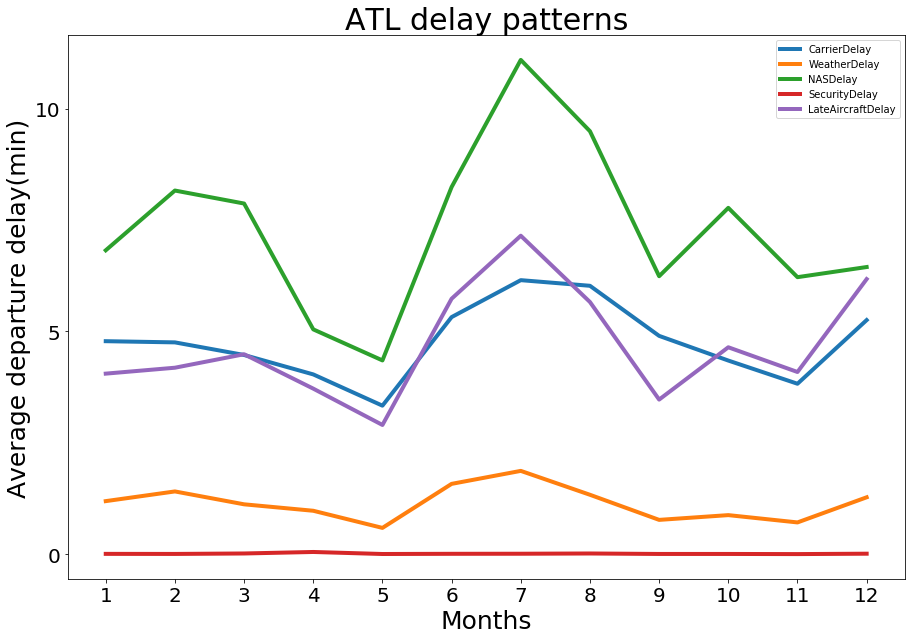

In [24]:
dfgbATL = df_final[df_final['Dest']=='ATL']
dfgbATL = dfgbATL.groupby(['Month'])
df_mean_by_apATL = dfgbATL.agg(['mean'])
df_mean_by_apATL

DelayReason = [ 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
plt.figure(figsize = (15,10))
for reason in DelayReason:
    means = df_mean_by_apATL[reason]['mean'].values
    plt.errorbar(np.arange(1, 13), means, label = reason, linewidth = 4)
plt.ylabel('Average departure delay(min)', size = 25)
plt.xlabel('Months', size = 25)
plt.yticks(np.arange(0, 15, 5), size = 20)
plt.xticks(np.arange(1,13),['1','2','3','4','5','6','7','8','9','10','11','12'], size = 20)
plt.title('ATL delay patterns', size=30)
plt.legend()

It looks like the major reason of delay in terms of minutes has changed, suggesting destination plays a role in delay reason. 

Finally let's look at it with respect to an less popular destination 'RDM'

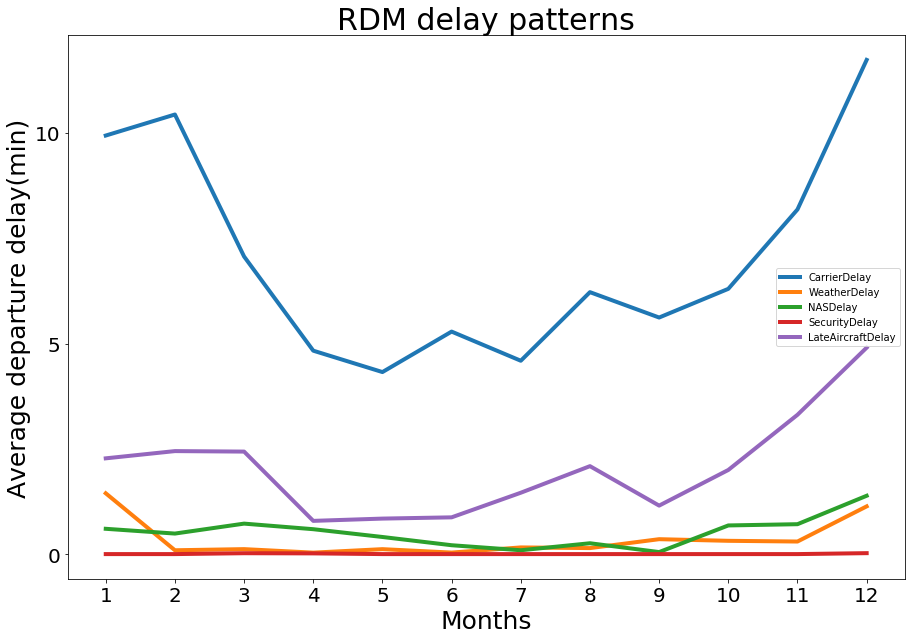

In [25]:
dfgbRDM = df_final[df_final['Dest']=='RDM']
dfgbRDM = dfgbRDM.groupby(['Month'])
df_mean_by_apRDM = dfgbRDM.agg(['mean'])
df_mean_by_apRDM

DelayReason = [ 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
plt.figure(figsize = (15,10))
for reason in DelayReason:
    means = df_mean_by_apRDM[reason]['mean'].values
    plt.errorbar(np.arange(1, 13), means, label = reason, linewidth = 4)
plt.ylabel('Average departure delay(min)', size = 25)
plt.xlabel('Months', size = 25)
plt.yticks(np.arange(0, 15, 5), size = 20)
plt.xticks(np.arange(1,13),['1','2','3','4','5','6','7','8','9','10','11','12'], size = 20)
plt.title('RDM delay patterns', size=30)
plt.legend()

# Data Analysis/ Result

In [27]:
#df_final['WeatherDelay'].plot()
dfgb = df_final.groupby(['Month'])
df_mean_by_apmonth = dfgb.agg(['mean'])
df_mean_by_apmonth


,Year,ArrDelay,DepDelay,Cancelled,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
,mean,mean,mean,mean,mean,mean,mean,mean,mean
Month,,,,,,,,,
1,2006.519296,8.770281,10.183391,0,4.398922,0.995643,4.660540,0.024391,5.584086
2,2006.513668,10.079116,11.179303,0,4.661406,1.050314,4.829308,0.031466,6.153434
3,2006.500476,9.210201,10.813852,0,4.444433,0.801404,4.580312,0.035115,5.890282
4,2006.505769,6.101138,7.848737,0,3.716128,0.583057,3.811203,0.028427,4.615676
5,2006.500478,5.736599,7.446081,0,3.464082,0.616716,3.782311,0.017605,4.444662
6,2006.503999,12.846501,13.412990,0,5.106689,1.261961,5.728112,0.027073,7.202234
7,2006.506906,12.325418,13.413387,0,5.271341,1.266751,5.469942,0.030764,7.346202
8,2006.495365,9.335448,10.836677,0,4.708913,0.954174,4.514669,0.055044,5.978859


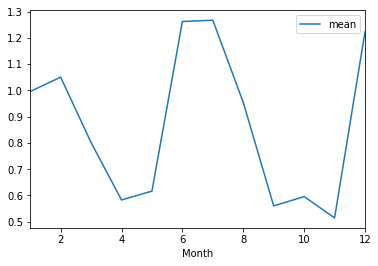

In [28]:
df_mean_by_apmonth['WeatherDelay'].plot()

In [29]:
df_final = df_final.fillna(0)
wd_sp = df_final[df_final['Season'] == 'spring']['WeatherDelay'].values
wd_sm = df_final[df_final['Season'] == 'summer']['WeatherDelay'].values
wd_wi = df_final[df_final['Season'] == 'winter']['WeatherDelay'].values
wd_fa = df_final[df_final['Season'] == 'fall']['WeatherDelay'].values

In [32]:
from statistics import mean
avg_wd_sp = mean(wd_sp)
avg_wd_sm = mean(wd_sm)
avg_wd_wi = mean(wd_wi)
avg_wd_fa = mean(wd_fa)

In [33]:
from scipy import stats
t_val1 = stats.ttest_ind(wd_fa, wd_wi)[0]
p_val1 = stats.ttest_ind(wd_fa, wd_wi)[1]
t_val2 = stats.ttest_ind(wd_sp, wd_sm)[0]
p_val2 = stats.ttest_ind(wd_sp, wd_sm)[1]

In [34]:
if p_val1 < 0.01:
    print('Data Science accomplished, there is a significant difference between weather delay during fall and winter!')
else:
    print('There is NOT a significant difference!')
if p_val2 < 0.01:
    print('Data Science accomplished, there is a significant difference between weather delay during spring and summer!')
else:
    print('There is NOT a significant difference!')

Data Science accomplished, there is a significant difference between weather delay during fall and winter!
Data Science accomplished, there is a significant difference between weather delay during spring and summer!


The first graph of this section shows departure delay in minutes throught the year of four different destinations. The next five graphs show the same thing but each of the graphs are of a differnt reason of delay. Departure delay has low delay points at month 5 and 9 of the year. The Late aircraft delay, weather delay, and carrier delay graphs all follow the same trend of Departure delay, having low delay points at month 5 and 9. This suggests that these reasons of delay are the ones that impact the delay in minutes the most, while the reasons of NAS delays and Security delays don't impact delay in minutes as much.  

The next three graphs show delay in minutes throughout the months but this time for the different reasons of delay in one graph. The first is a general graph with means encompassing all of the aircraft destinations. The next graph of the three is based on only the most popular destination 'ATL' and the last of the three graphs is based on a less populular destination 'RDM.' It is important to note that this is in terms of minutes and not airport counts. These graphs suggest that there is an importance in destination in the major reason of delay, since each graph had a diffrent top reason of delay. This is in line with our hypothesis as there is a relationship between destination and reason of delay. Another important result of these graphs was that although genereally Late Aircraft delay was a major reaason of delay, when the graphs were based on the most popular destination and to a less popular destination, it wasn't the case. So our hypothesis was wrong, it is only generally true that Late aircraft delay is the major reason for delay. It isn't true when split into different destinations. 

Finally, our tests have shown differences in weather delay between the seasons, which makes sense. 

In [36]:
late_aircraft_delay = df_final['LateAircraftDelay']
arrival_delay = df_final['ArrDelay']
departure_delay = df_final['DepDelay']

In [46]:
import statsmodels.api as sm
model = sm.OLS(arrival_delay, late_aircraft_delay)
res = model.fit()
res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ArrDelay   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                 1.822e+07
Date:                Thu, 22 Mar 2018   Prob (F-statistic):               0.00
Time:                        19:08:51   Log-Likelihood:            -1.3565e+08
No. Observations:            28191615   AIC:                         2.713e+08
Df Residuals:                28191614   BIC:                         2.713e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
LateAircraftDelay     1.1683      0.000   4268.224      0.000       1.168       1.169
==============================================================================
Omnibus:                 38257720.536   Durbin-Watson:                   1.731
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      24479911858.113
Skew:                           7.467   Prob(JB):                         0.00
Kurtosis:                     146.587   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Because the p-value is ~0, late aircraft delay is a significant predictor of a plane's arrival delay. We see the linear regression below.

In [53]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
late_aircraft_delay_rs = late_aircraft_delay.reshape(-1, 1)
arrival_delay_rs = arrival_delay.reshape(-1, 1)
reg.fit(late_aircraft_delay_rs, arrival_delay_rs) #arrival_delay = a0 + a1*late_aircraft_delay

print("arrival_delay =", reg.intercept_[0], "+", reg.coef_[0][0], "*late_aircraft_delay")


/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


arrival_delay = 3.41547069303 + 1.13125260004 *late_aircraft_delay


In [47]:
model1 = sm.OLS(departure_delay, late_aircraft_delay)
res1 = model1.fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               DepDelay   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                 2.201e+07
Date:                Thu, 22 Mar 2018   Prob (F-statistic):               0.00
Time:                        19:09:45   Log-Likelihood:            -1.3255e+08
No. Observations:            28191615   AIC:                         2.651e+08
Df Residuals:                28191614   BIC:                         2.651e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
LateAircraftDelay     1.1506      0.000   4691.578      0.000       1.150       1.151
==============================================================================
Omnibus:                 42887008.923   Durbin-Watson:                   1.767
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      80788366658.535
Skew:                           8.994   Prob(JB):                         0.00
Kurtosis:                     264.635   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Because the p-value is ~0, late aircraft delay is a significant predictor of a plane's departure delay. We see the linear regression below.

In [55]:
reg1 = linear_model.LinearRegression()
late_aircraft_delay_rs = late_aircraft_delay.reshape(-1, 1)
departure_delay_rs = departure_delay.reshape(-1, 1)
reg1.fit(late_aircraft_delay_rs, departure_delay_rs) #arrival_delay = a0 + a1*late_aircraft_delay

print("departure_delay =", reg1.intercept_[0], "+", reg1.coef_[0][0], "*late_aircraft_delay")

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()


departure_delay = 5.06980910098 + 1.09564372215 *late_aircraft_delay


# Privacy/ethics considerations 

The data we are using is public. Since they are about aircraft flights, the location based information is not a privacy concern. Nothing invades personal privacy of anybody. There are no seen biases in the data, and it allows for  equitable analysis since people themselves aren't even recorded in the data. We do not see any potential issues that would affect privacy or equitable analysis.

# Conclusions and Discussion 

Our analysis and results of our tests and visualizations have given us important information about flight delays with respect to destination, reason, and time of year. 

Our data have shown us that LateAircraft delay, weather delay and carrier delay are the reasons that impact minutes of delay the most. From this, we think that if we are to decrease minutes of aircraft delay, these are what should be focused on. We have also learned that destination affects which reason of delay is affecting the delay the most. Furthermore, when separated in terms of destination, the delay in minutes throughout the year is different between the destinations. So if trying to avoid the delay, we should look at different months of the year based on different destinations. This is because each destination has different volumes of traffic during the different months in the year, and some months can sufficiently prove to be better to travel during in order to avoid getting into delays. This would make sense since in some months (for eg. especially holiday season in december) the volume of traffic at airports is high since people are going back to their homes or going somewhere on the holiday. 